## 1. Churn Prediction

In [1]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import yeojohnson

import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense

2025-08-24 10:20:41.781354: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-24 10:20:41.786011: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-24 10:20:41.823597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-24 10:20:41.823631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-24 10:20:41.824704: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
#Reading the datasets
df_loyalty= pd.read_csv("Loyalty.csv")
df_activity_agg = pd.read_csv('Aggregated Activity.csv')

In [3]:
#Dropping unused columns
df_loyalty.drop(columns = ['Country','Province','City'],inplace = True)

In [4]:
#Merging loyalty and activity aggregated data on the basis of Loyalty Number
df_churn = pd.merge(df_loyalty, df_activity_agg, on="Loyalty Number", how='inner')
df_churn.head()

,Loyalty Number,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,480934,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,0.0,0.0,2016-02-01,NaN,37,54525,54525.0,1418,256
1,530508,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,0.0,0.0,2014-10-01,NaN,37,55515,55515.0,0,0
2,193662,Y2K 6R0,Male,Bachelor,51124.0,Married,Star,3844.57,Standard,2012,5,0.0,0.0,2012-05-01,NaN,86,138596,138596.0,1222,220
3,188893,K8V 4B2,Male,Bachelor,100159.0,Married,Star,3861.49,Standard,2016,12,0.0,0.0,2016-12-01,NaN,41,72849,72849.0,733,132
4,852392,H2Y 2W2,Female,Bachelor,100159.0,Married,Star,3861.49,Standard,2015,5,0.0,0.0,2015-05-01,NaN,27,48968,48968.0,1516,274


In [5]:
#Converting the date columns into the appropriate date data type.
df_churn['Enrollment Date'] = pd.to_datetime(df_churn['Enrollment Date'])
df_churn['Cancellation Date'] = pd.to_datetime(df_churn['Cancellation Date'])

#Applying the Ordinal encoder on the categorical columns
categorical_cols = ['Postal Code','Gender','Education','Marital Status','Loyalty Card','Enrollment Type']
encoder = OrdinalEncoder()
df_churn[categorical_cols] = encoder.fit_transform(df_churn[categorical_cols])

The activity and loyalty data end at December 2018. So we will consider Jan 2019 for the tenure duration (in months).

In [6]:
#Creating a tenure month column that subtracts the enrollment and cancellation dates (if present, else Jan 2019)
#Using dt.days we can obtain the number of days between the duration
#Dividing by 30.44 to convert to months as 364.25/12
df_churn['tenure months'] = (df_churn['Cancellation Date'] - df_churn['Enrollment Date']).dt.days/30.44
df_churn['tenure months'] = df_churn['tenure months'].fillna((pd.Timestamp('2019-01-01')-df_churn['Enrollment Date']).dt.days/30.44)
df_churn['churn'] = df_churn['Cancellation Date'].isnull().astype(int)

In [7]:
#Selecting only the useful columns from the entire dataset
df_churn2 = df_churn[['Postal Code', 'Gender', 'Education', 'Salary',
       'Marital Status', 'Loyalty Card', 'Enrollment Type','Total Flights', 'Distance', 'Points Accumulated', 'Points Redeemed',
       'Dollar Cost Points Redeemed', 'tenure months', 'CLV','churn']]
df_churn2.head()

,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,Enrollment Type,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,tenure months,CLV,churn
0,24.0,0.0,0.0,83236.0,1.0,2.0,1.0,37,54525,54525.0,1418,256,34.986859,3839.14,1
1,15.0,1.0,0.0,103495.0,1.0,2.0,1.0,37,55515,55515.0,0,0,51.018397,3842.79,1
2,54.0,1.0,0.0,51124.0,1.0,2.0,1.0,86,138596,138596.0,1222,220,80.026281,3844.57,1
3,19.0,1.0,0.0,100159.0,1.0,2.0,1.0,41,72849,72849.0,733,132,25.000000,3861.49,1
4,9.0,0.0,0.0,100159.0,1.0,2.0,1.0,27,48968,48968.0,1516,274,44.053876,3861.49,1


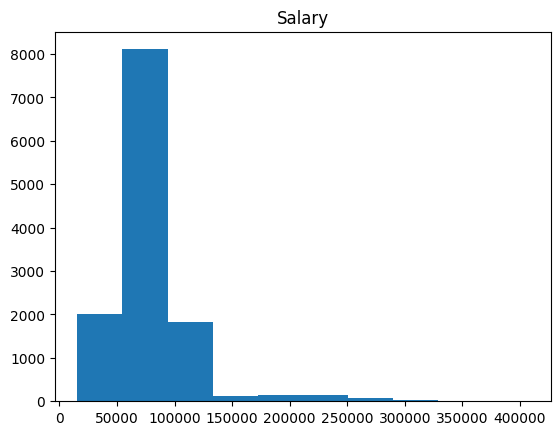

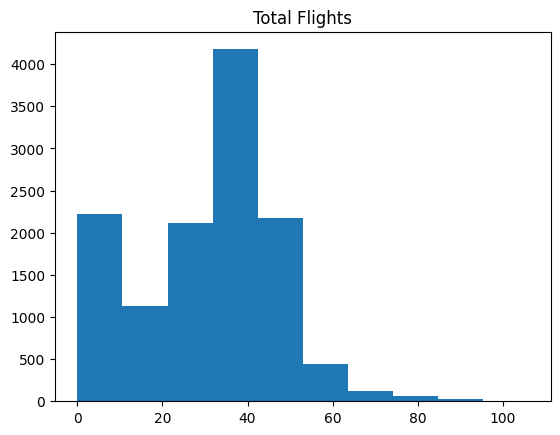

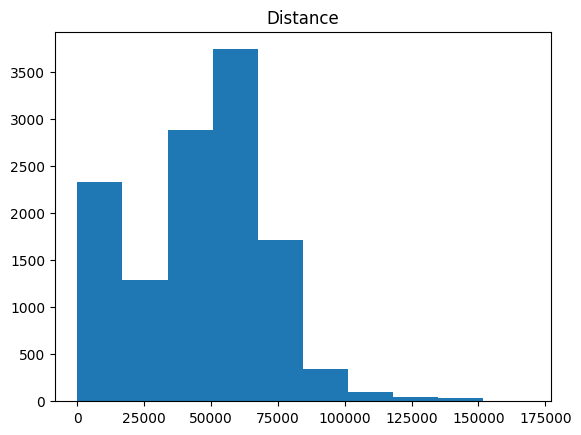

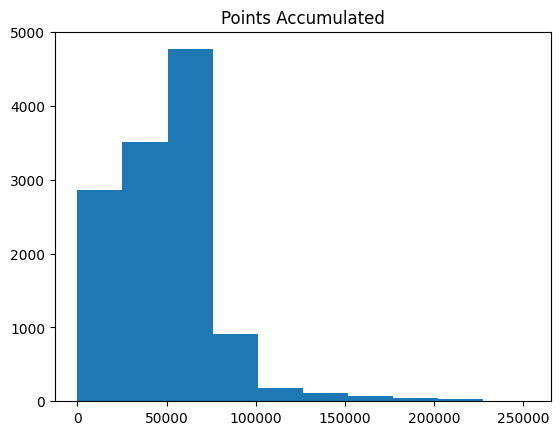

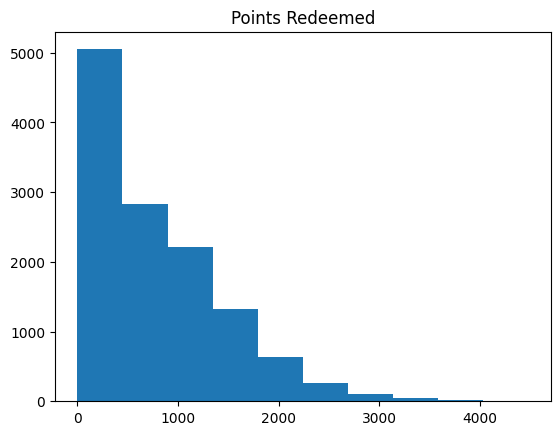

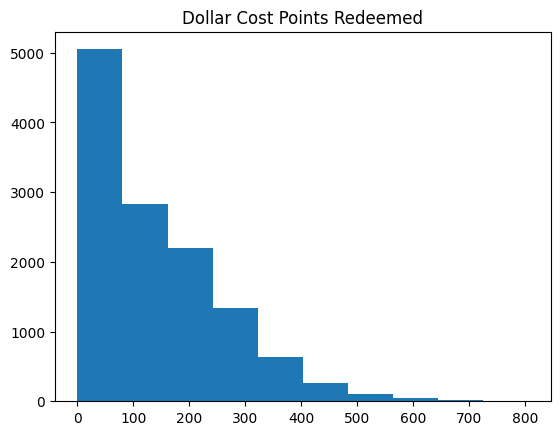

In [8]:
#Evalutating the distribution of data within the numerical columns
for i in ['Salary','Total Flights', 'Distance', 'Points Accumulated', 'Points Redeemed',
       'Dollar Cost Points Redeemed']:
       plt.hist(df_churn2[i])
       plt.title(i)
       plt.show()

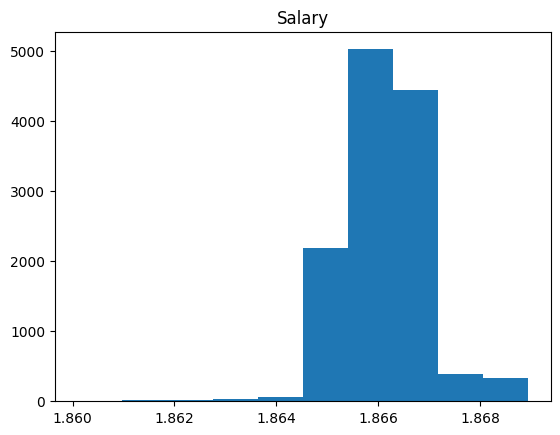

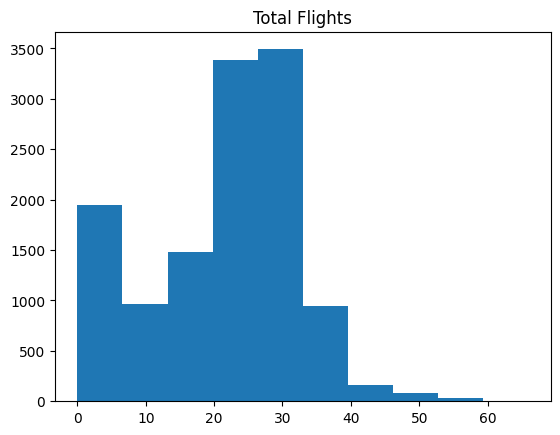

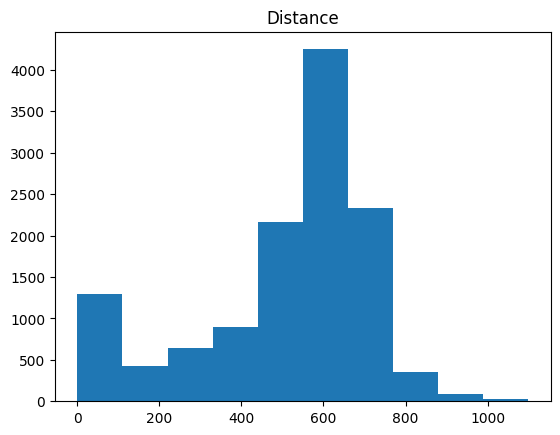

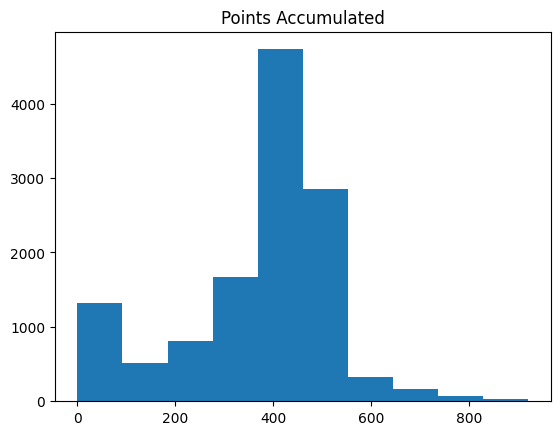

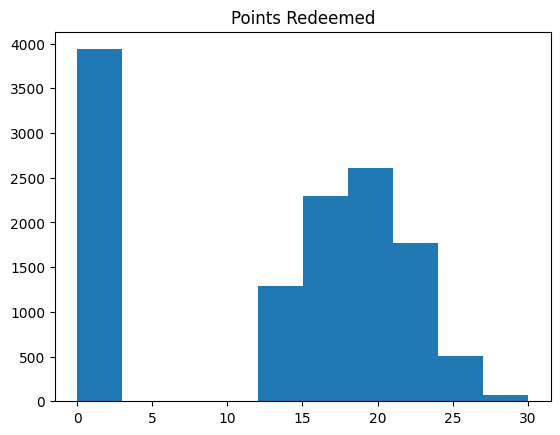

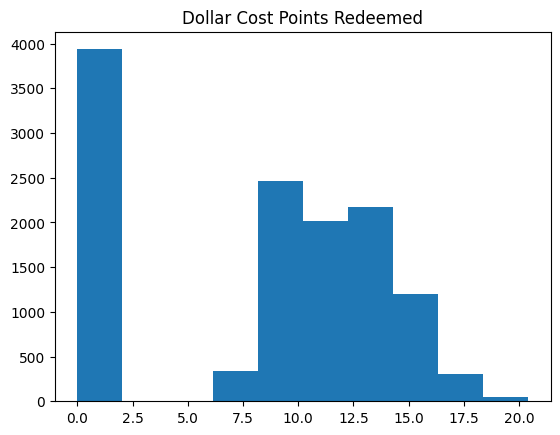

In [9]:
#Evalutating the distribution of data within the numerical columns, after applying necessary transformations to reduce skewness
for i in ['Salary','Total Flights', 'Distance', 'Points Accumulated', 'Points Redeemed',
       'Dollar Cost Points Redeemed']:
       vals = yeojohnson(df_churn2[i])[0]
       plt.hist(vals)
       plt.title(i)
       plt.show()

In [10]:
#Since the data is skewed, we will apply necessary transformations
df_churn2.loc[:,'Salary'] = yeojohnson(df_churn2['Salary'])[0]
df_churn2.loc[:,'Distance'] = yeojohnson(df_churn2['Distance'])[0]
df_churn2.loc[:,'Dollar Cost Points Redeemed'] = yeojohnson(df_churn2['Dollar Cost Points Redeemed'])[0]
df_churn2.loc[:,'Points Redeemed'] = yeojohnson(df_churn2['Points Redeemed'])[0]
df_churn2.loc[:,'Total Flights'] = yeojohnson(df_churn2['Total Flights'])[0]
df_churn2.loc[:,'Points Accumulated'] = yeojohnson(df_churn2['Points Accumulated'])[0]

In [11]:
df_churn2.head()

,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,Enrollment Type,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,tenure months,CLV,churn
0,24.0,0.0,0.0,1.866439,1.0,2.0,1.0,26.104473,604.070001,432.201658,21.339337,13.707269,34.986859,3839.14,1
1,15.0,1.0,0.0,1.866921,1.0,2.0,1.0,26.104473,609.866110,436.061475,0.000000,0.000000,51.018397,3842.79,1
2,54.0,1.0,0.0,1.865134,1.0,2.0,1.0,54.899650,990.752599,685.008361,20.390496,12.976032,80.026281,3844.57,1
3,19.0,1.0,0.0,1.866852,1.0,2.0,1.0,28.585310,704.449476,498.701361,17.395249,10.736526,25.000000,3861.49,1
4,9.0,0.0,0.0,1.866852,1.0,2.0,1.0,19.742717,570.571311,409.842004,21.777618,14.045759,44.053876,3861.49,1


In [12]:
#Normalizing the values
scaler = MinMaxScaler()
df_churn2.loc[:,['Total Flights', 'Distance', 'Points Accumulated', 'Points Redeemed',
       'Dollar Cost Points Redeemed', 'tenure months','Salary','CLV']] = scaler.fit_transform(df_churn2[['Total Flights', 'Distance', 'Points Accumulated', 'Points Redeemed',
       'Dollar Cost Points Redeemed', 'tenure months','Salary','CLV']])

In [13]:
df_churn2.describe()

,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,Enrollment Type,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,tenure months,CLV,churn
count,12479.000000,12479.000000,12479.000000,12479.000000,12479.000000,12479.000000,12479.000000,12479.000000,12479.000000,12479.000000,12479.000000,12479.000000,12479.000000,12479.000000,12479.000000
mean,28.341694,0.493870,0.306114,0.678728,0.993189,1.231188,0.942864,0.323723,0.459952,0.399857,0.429667,0.397268,0.449643,0.073885,0.876753
std,16.707215,0.499982,0.762808,0.089031,0.579780,0.774349,0.232112,0.170674,0.201987,0.176902,0.305910,0.288218,0.303313,0.085533,0.328734
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,0.000000,0.000000,0.617999,1.000000,1.000000,1.000000,0.218891,0.387038,0.340178,0.000000,0.000000,0.148013,0.024164,1.000000
50%,29.000000,0.000000,0.000000,0.682602,1.000000,1.000000,1.000000,0.367209,0.521919,0.449023,0.533305,0.476378,0.420114,0.045428,1.000000
75%,45.000000,1.000000,0.000000,0.732890,1.000000,2.000000,1.000000,0.442692,0.592691,0.506606,0.668546,0.624796,0.716545,0.085608,1.000000
max,54.000000,1.000000,3.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
#Splitting the dataset into training and testing
x,y = df_churn2.iloc[:, :-1], df_churn2.iloc[:, -1]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = 0.20, random_state = 47)

In [15]:
#Fitting multiple models on the data to identify the best as per the accuracy
models = {
    'Decision Tree':DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'KNN':KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()}

for name, model in models.items():
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    print(name, accuracy_score(ypred, ytest))

Decision Tree 0.9370993589743589
/root/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Logistic Regression 0.9078525641025641
SVM 0.874198717948718
KNN 0.875
Random Forest 0.9579326923076923


In [16]:
#Checking best hyperparameters for Random Forest Classifier
cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 47)
model =  RandomForestClassifier()
params = {'n_estimators':[20,50,100], 'max_depth' : [5,10,20, None]}
model_params = GridSearchCV(model, params, cv = cv)
model_params.fit(xtrain, ytrain)
model_params.best_params_, model_params.best_score_

({'max_depth': 20, 'n_estimators': 100}, 0.9576950930738125)

In [17]:
#Checking best hyperparameters for SVC
cv = RepeatedKFold(n_splits = 3, n_repeats = 2, random_state = 47)
model =  SVC()
params = {'kernel':['linear','poly','rbf']}
model_params = GridSearchCV(model, params, cv = cv)
model_params.fit(xtrain, ytrain)
model_params.best_params_, model_params.best_score_

({'kernel': 'linear'}, 0.8773920900431976)

In [18]:
#Since the best model is the Random Forest Classifier, training it with the optimal hyperparameters
final_model = RandomForestClassifier(n_estimators = 100, max_depth=20)
final_model.fit(xtrain, ytrain)
accuracy_score(final_model.predict(xtest), ytest)

0.9599358974358975

In [19]:
#Testing a deep neural network for classification
deep_model = Sequential()
deep_model.add(Dense(units = 16, activation = 'relu'))
deep_model.add(Dense(units = 32, activation = 'relu'))
deep_model.add(Dense(units = 1, activation = 'sigmoid'))

deep_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
deep_model.fit(xtrain, ytrain, epochs = 10, batch_size = 100)
ypred = deep_model.predict(xtest)
labels_pred = []
for i in ypred:
    if i<0.5:
        labels_pred.append(0)
    else:
        labels_pred.append(1)
accuracy_score(labels_pred, ytest)

Epoch 1/10
100/100 [==============================] - 1s 1ms/step - loss: 0.5459 - accuracy: 0.7167
Epoch 2/10
100/100 [==============================] - 0s 982us/step - loss: 0.2898 - accuracy: 0.8783
Epoch 3/10
100/100 [==============================] - 0s 822us/step - loss: 0.2722 - accuracy: 0.8833
Epoch 4/10
100/100 [==============================] - 0s 957us/step - loss: 0.2666 - accuracy: 0.8865
Epoch 5/10
100/100 [==============================] - 0s 965us/step - loss: 0.2643 - accuracy: 0.8890
Epoch 6/10
100/100 [==============================] - 0s 910us/step - loss: 0.2613 - accuracy: 0.8886
Epoch 7/10
100/100 [==============================] - 0s 924us/step - loss: 0.2622 - accuracy: 0.8889
Epoch 8/10
100/100 [==============================] - 0s 966us/step - loss: 0.2599 - accuracy: 0.8942
Epoch 9/10
100/100 [==============================] - 0s 1ms/step - loss: 0.2581 - accuracy: 0.8967
Epoch 10/10
78/78 [==============================] - 0s 773us/step


0.9014423076923077

Best Model - Random Forest with 95% accuracy

In [20]:
#Exporting the model, fitted scaler and encoder
import pickle
with open('churn_model.bin','wb') as file:
    pickle.dump((final_model, scaler, encoder), file)

In [21]:
df_clv = df_churn[['Postal Code', 'Gender', 'Education', 'Salary',
       'Marital Status', 'Loyalty Card', 'Enrollment Type','Total Flights', 'Distance', 'Points Accumulated', 'Points Redeemed',
       'Dollar Cost Points Redeemed', 'tenure months','CLV']]

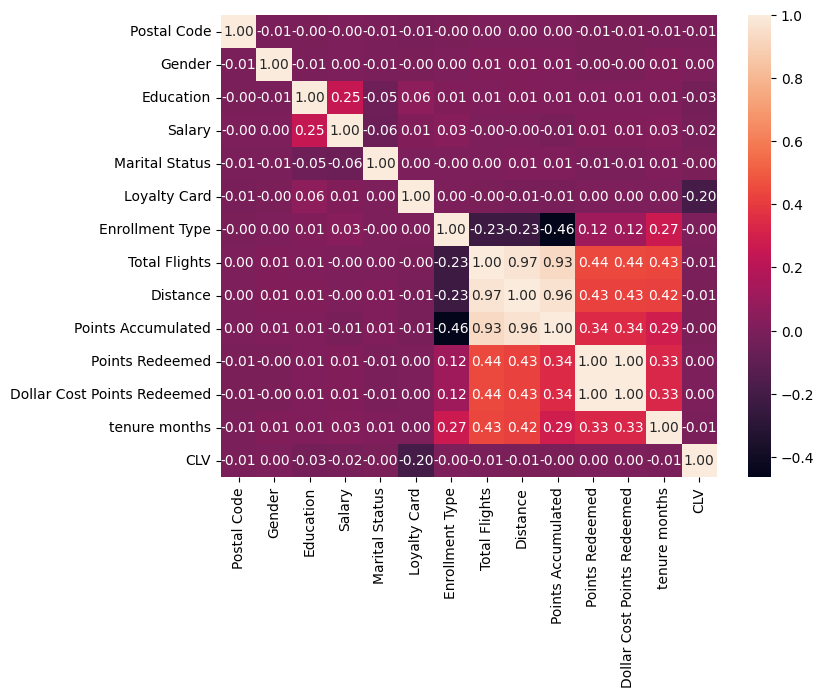

In [22]:
plt.figure(figsize = (8,6))
sns.heatmap(df_clv.corr(), annot = True, fmt = ".2f", cmap = "rocket")
plt.show()

Results from the heatmap: It is evident that there is weak or no correlation of the features with the CLV column. Hence, applying regression models on this data to predict the customer lifetime value would not result in the best models, since columns are not able to explain the variation in the CLV.

Note: Multiple regression models were tested on the data, but they produced poor results, hence they have been excluded from this notebook.

### Time Series Analysis

In [23]:
!pip install prophet
!pip install statsmodels


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [24]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

/root/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
#Reading the flight activity dataset for time series analysis on flights.
df_activity = pd.read_csv('Customer Flight Activity.csv')
df_activity.head()

,Loyalty Number,Year,Month,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100590,2018,6,12,15276,22914.0,0,0
1,100590,2018,7,12,9168,13752.0,0,0
2,100590,2018,5,4,6504,9756.0,0,0
3,100590,2018,10,0,0,0.0,512,92
4,100590,2018,2,0,0,0.0,0,0


In [26]:
#Converting the year and month columns into a datetime column
df_activity['ds'] = pd.to_datetime(df_activity['Year'].astype(str) + '-'+df_activity['Month'].astype(str) + '-01' )
df_activity.head()

,Loyalty Number,Year,Month,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,ds
0,100590,2018,6,12,15276,22914.0,0,0,2018-06-01
1,100590,2018,7,12,9168,13752.0,0,0,2018-07-01
2,100590,2018,5,4,6504,9756.0,0,0,2018-05-01
3,100590,2018,10,0,0,0.0,512,92,2018-10-01
4,100590,2018,2,0,0,0.0,0,0,2018-02-01


In [27]:
#Selecting only the date and total flights column for the Prophet model 
df_ts_activity = df_activity.loc[:,['ds','Total Flights']]
df_ts_activity.rename(columns = {'Total Flights': 'y'}, inplace = True)
df_ts_activity = df_ts_activity.groupby('ds')['y'].sum().reset_index()

In [28]:
df_ts_activity.head()

,ds,y
0,2017-01-01,13059
1,2017-02-01,13368
2,2017-03-01,18391
3,2017-04-01,15449
4,2017-05-01,18690


In [29]:
df_ts_activity.tail()

,ds,y
19,2018-08-01,32808
20,2018-09-01,22034
21,2018-10-01,20696
22,2018-11-01,19673
23,2018-12-01,28857


In [30]:
model = Prophet(yearly_seasonality=True)
model.fit(df_ts_activity)

10:23:33 - cmdstanpy - INFO - Chain [1] start processing
10:23:33 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
future = model.make_future_dataframe(periods = 12, freq = 'MS')
future.tail()

,ds
31,2019-08-01
32,2019-09-01
33,2019-10-01
34,2019-11-01
35,2019-12-01


In [32]:
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,15122.048320,9027.940067,13181.692468,15122.048320,15122.048320,-4165.079352,-4165.079352,-4165.079352,-4165.079352,-4165.079352,-4165.079352,0.0,0.0,0.0,10956.968968
1,2017-02-01,15556.974031,8797.936130,12990.125698,15556.974031,15556.974031,-4629.377520,-4629.377520,-4629.377520,-4629.377520,-4629.377520,-4629.377520,0.0,0.0,0.0,10927.596511
2,2017-03-01,15949.810148,14494.823347,18787.361046,15949.810148,15949.810148,693.624097,693.624097,693.624097,693.624097,693.624097,693.624097,0.0,0.0,0.0,16643.434245
3,2017-04-01,16384.735834,13037.593098,17136.214034,16384.735834,16384.735834,-1330.572668,-1330.572668,-1330.572668,-1330.572668,-1330.572668,-1330.572668,0.0,0.0,0.0,15054.163166
4,2017-05-01,16805.631676,17416.819979,21468.196576,16805.631676,16805.631676,2711.260435,2711.260435,2711.260435,2711.260435,2711.260435,2711.260435,0.0,0.0,0.0,19516.892111
5,2017-06-01,17240.677244,23267.890245,27266.437274,17240.677244,17240.677244,8044.326837,8044.326837,8044.326837,8044.326837,8044.326837,8044.326837,0.0,0.0,0.0,25285.004081
6,2017-07-01,17662.528020,26341.761850,30487.949569,17662.528020,17662.528020,10860.444761,10860.444761,10860.444761,10860.444761,10860.444761,10860.444761,0.0,0.0,0.0,28522.972781
7,2017-08-01,18098.524623,22968.385248,26991.814378,18098.524623,18098.524623,6901.496215,6901.496215,6901.496215,6901.496215,6901.496215,6901.496215,0.0,0.0,0.0,25000.020838
8,2017-09-01,18535.428272,16900.046071,21204.236670,18535.428272,18535.428272,377.730441,377.730441,377.730441,377.730441,377.730441,377.730441,0.0,0.0,0.0,18913.158713
9,2017-10-01,18959.221431,14966.668049,19067.943526,18959.221431,18959.221431,-1985.991092,-1985.991092,-1985.991092,-1985.991092,-1985.991092,-1985.991092,0.0,0.0,0.0,16973.230339


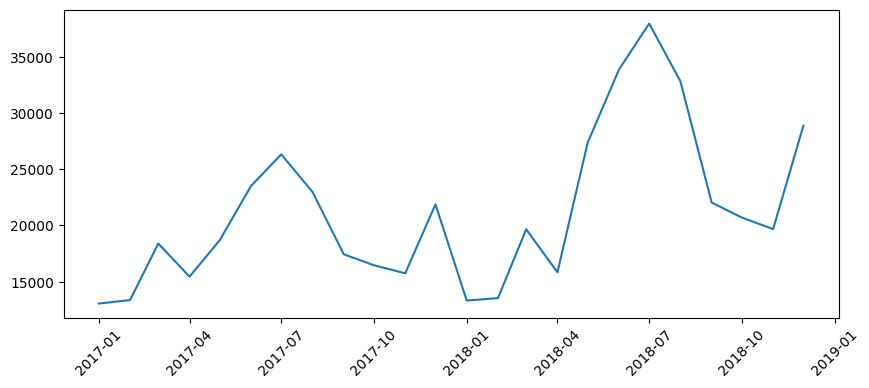

In [33]:
#Plotting the original data
plt.figure(figsize = (10,4))
plt.plot(df_ts_activity['ds'], df_ts_activity['y'])
plt.xticks(rotation = 45)
plt.show()

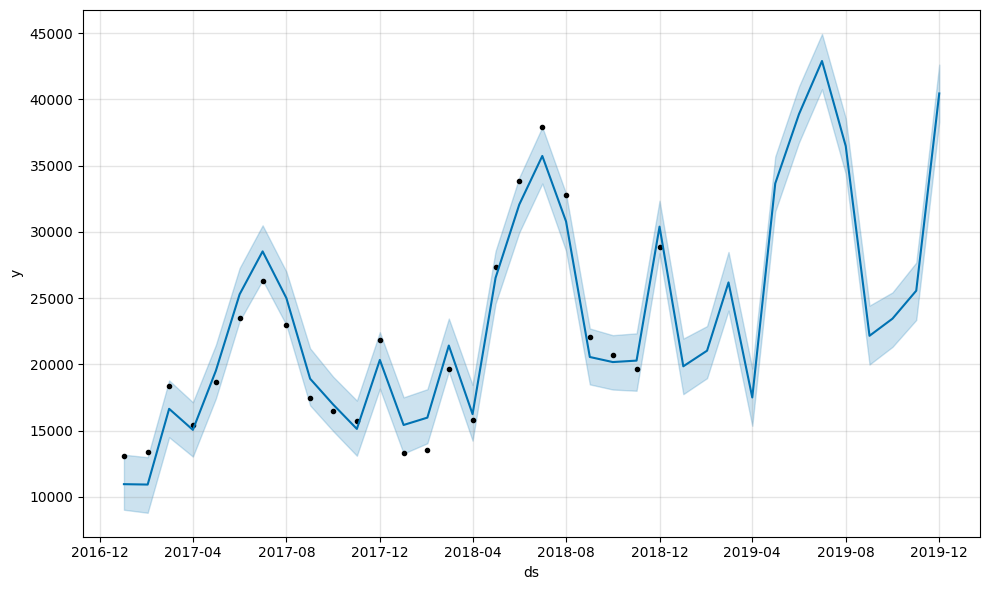

In [34]:
#Plotting the original data and the forecast for the next year (2019)
fig1 = model.plot(forecast)

Analysis from the forecast: The prediction indicates an increasing trend in the flights.

In [35]:
df_ts_activity.set_index('ds', inplace = True)

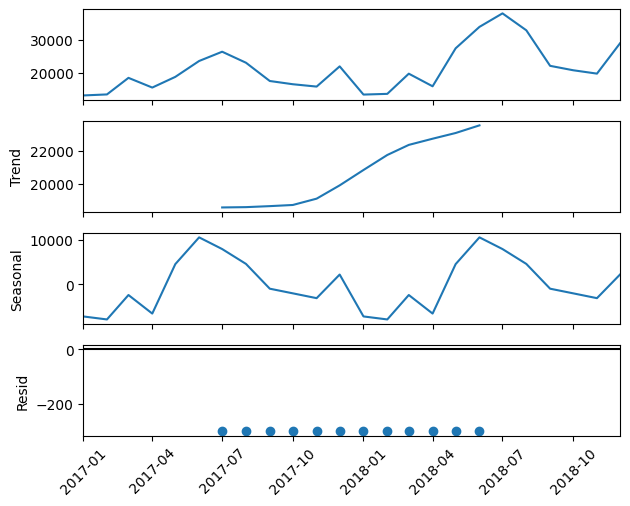

In [36]:
#Decomposing the flights data to inspect individual components.
result = seasonal_decompose(df_ts_activity)
result.plot()
plt.xticks(rotation = 45, fontsize = 10)
plt.show()

Analysis from decomposition: It is evident there is a seasonal variation in the data as the flights increase between May - August, with drop in Jan & Feb.

In [37]:
#Conduting decompostion on the loyalty data, specifically for the enrollments.
df_loyalty = pd.read_csv('Customer Loyalty History.csv')
df_loyalty.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,0.0,0.0
1,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,0.0,0.0
2,193662,Canada,Yukon,Whitehorse,Y2K 6R0,Male,Bachelor,51124.0,Married,Star,3844.57,Standard,2012,5,0.0,0.0
3,188893,Canada,Ontario,Trenton,K8V 4B2,Male,Bachelor,100159.0,Married,Star,3861.49,Standard,2016,12,0.0,0.0
4,852392,Canada,Quebec,Montreal,H2Y 2W2,Female,Bachelor,100159.0,Married,Star,3861.49,Standard,2015,5,0.0,0.0


In [38]:
df_loyalty['ds'] = pd.to_datetime(df_loyalty['Enrollment Year'].astype(str) + '-'+df_loyalty['Enrollment Month'].astype(str) + '-01' )
df_loyalty.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,ds
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,0.0,0.0,2016-02-01
1,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,0.0,0.0,2014-10-01
2,193662,Canada,Yukon,Whitehorse,Y2K 6R0,Male,Bachelor,51124.0,Married,Star,3844.57,Standard,2012,5,0.0,0.0,2012-05-01
3,188893,Canada,Ontario,Trenton,K8V 4B2,Male,Bachelor,100159.0,Married,Star,3861.49,Standard,2016,12,0.0,0.0,2016-12-01
4,852392,Canada,Quebec,Montreal,H2Y 2W2,Female,Bachelor,100159.0,Married,Star,3861.49,Standard,2015,5,0.0,0.0,2015-05-01


In [39]:
df_ts_loyalty = df_loyalty.loc[:,['ds','Loyalty Number']]
df_ts_loyalty.rename(columns = {'Loyalty Number': 'y'}, inplace = True)
df_ts_loyalty = df_ts_loyalty.groupby('ds')['y'].count().reset_index()

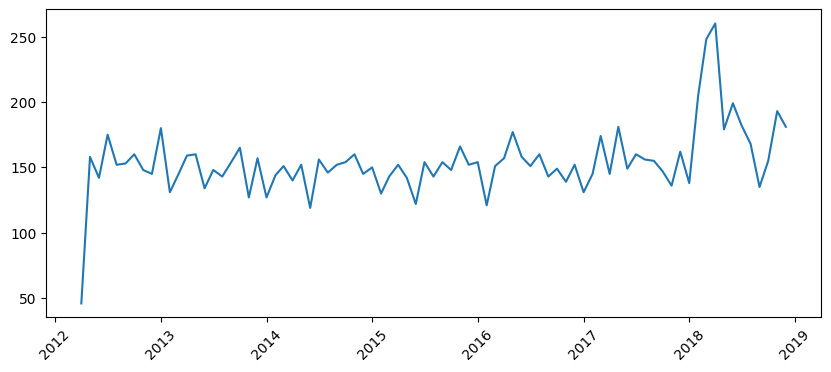

In [40]:
#Plotting the original data
plt.figure(figsize = (10,4))
plt.plot(df_ts_loyalty['ds'], df_ts_loyalty['y'])
plt.xticks(rotation = 45)
plt.show()

In [41]:
df_ts_loyalty.set_index('ds', inplace = True)
df_ts_loyalty.head()

,y
ds,
2012-04-01,46
2012-05-01,158
2012-06-01,142
2012-07-01,175
2012-08-01,152


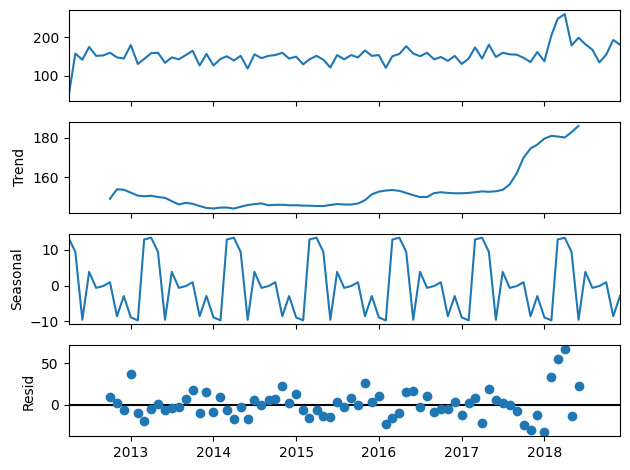

In [42]:
results = seasonal_decompose(df_ts_loyalty)
results.plot()
plt.show()

Analysis from the decomposition: It is evident that there is a seasonal component in the enrollments. Enrollments see a huge spike in March-May, a smaller spike in July-September, with enrollments decreasing at the start and end of the year. The sudden spike at the end of the trend plot, signifies the promotion conducted by the Northern Lights Air, resulting in increased enrollments.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bc8f4021-1e31-4083-96cf-7f62db2bc526' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>